Δημιουργία ενός _real system_ για προσομοίωση του πραγματικού συστήματος. Στους τελικούς υπολογισμούς των X και S από το _real system_ προσθέτω noise ή χρησιμοποιώ διαφορετικό 'real' model.

Maximum biomass concentration: 23.58 g/l at time 5.00 hours


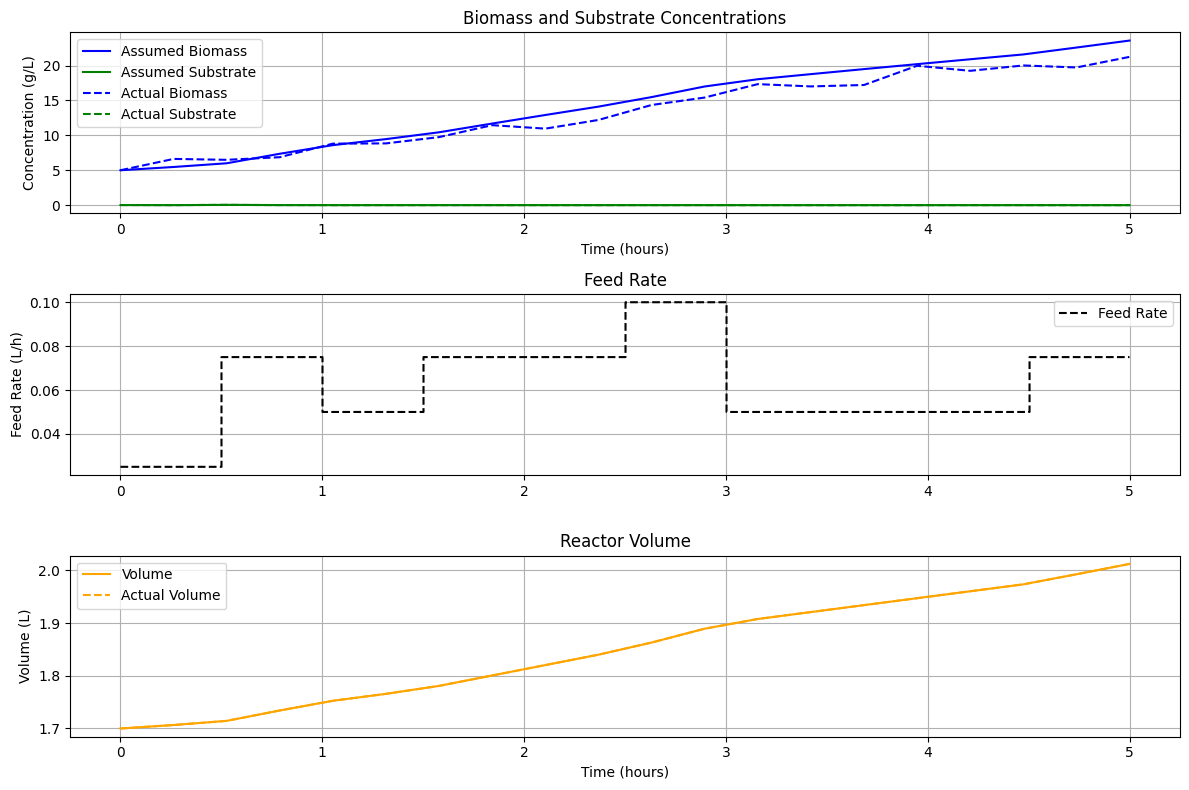

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Number of data points
NUM_SAMPLES = 1000

# Kinetic parameters
MU_MAX = 0.86980      # 1/h
K_S    = 0.00123762   # g/l
Y_XS   = 0.4357       # g/g
Y_PX   = 0.2          # g/g
S_F    = 1.43 * 200   # g/l
K_I    = 33           # g/l
k_d    = 0.03        # 1/h

# Initial conditions
X_0 = 5
S_0 = 0.013
V_0 = 1.7

# ODE solver parameters
ODE_SOLVER = 'RK45'

# Time parameters
T_START = 0
T_END = 5
TIME_RANGE = int(T_END - T_START) # Absolute time 
dt = 0.5

# Noise parameters
BIOMASS_NOISE = 0.035
SUBSTRATE_NOISE = 0.03

# Feed rate (random function)
def Fs(t, random: bool=True):
    if random:
        return np.random.choice([0, 0.1, 0.05, 0.025, 0.075])
    else:
        # Define a piecewise feed rate function
        if 0 <= t < 1:
            return 0.01
        elif 1 <= t < 2:
            return 0.025
        elif 2 <= t < 3:
            return 0.05
        elif 3 <= t < 4:
            return 0.075
        else:
            return 0.1

# Actual system model with cell death and substrate inhibition
def actual_system(t, y, F_func: callable, k_d: float = k_d):
    X, S, V = y
    F = F_func(t)
    mu = MU_MAX * S / (K_S + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

# Assumed system model 
def dynamic_system(t, y, F_func: callable):
    ''' Real system model with cell death and substrate inhibition '''
    X, S, V = y
    F = F_func(t)
    mu = MU_MAX * S / (K_S + S)  # Monod equation
    dX_dt = mu * X - (F / V) * X 
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S) 
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]


def simulate(F: callable, plot: bool=True, real: bool=True) -> np.ndarray:
    """ Simulate bioreactor system using ODEs 
    - F: feed rate (assumed constant)
    - real: if True, simulate also the real system model; otherwise, only plant model
    """
    t_points   = np.arange(T_START, T_END, dt)
    F_func = interp1d(t_points, [F(t) for t in t_points], kind="previous", fill_value="extrapolate")
    
    t_eval = np.linspace(T_START, T_END, 20)
    sol = solve_ivp(dynamic_system, t_span=(T_START, T_END), y0=[X_0, S_0, V_0], args=(F_func,), t_eval=t_eval, method='LSODA', rtol=1e-6, atol=1e-12)

    if real:
        # Simulate the real system
        sol_real = solve_ivp(actual_system, t_span=(T_START, T_END), y0=[X_0, S_0, V_0], args=(F_func,), t_eval=t_eval, method='LSODA', rtol=1e-6, atol=1e-12)
        # Add noise to the real system
        sol_real.y[0][1:] += np.random.normal(0, sol_real.y[0].max() * BIOMASS_NOISE, size=sol_real.y[0][1:].shape)
        sol_real.y[1][1:] += np.random.normal(0, sol_real.y[1].max() * SUBSTRATE_NOISE, size=sol_real.y[1][1:].shape)
    
    print(f'Maximum biomass concentration: {np.max(sol.y[0]):.2f} g/l at time {sol.t[np.argmax(sol.y[0])]:.2f} hours')
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot Biomass and Substrate
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(sol.t, sol.y[0], label='Assumed Biomass', color='blue')
        ax1.plot(sol.t, sol.y[1], label='Assumed Substrate', color='green')
        if real:
            ax1.plot(sol_real.t, sol_real.y[0], label='Actual Biomass', color='blue', linestyle='--')
            ax1.plot(sol_real.t, sol_real.y[1], label='Actual Substrate', color='green', linestyle='--')
        ax1.set_title('Biomass and Substrate Concentrations')
        ax1.set_xlabel('Time (hours)')
        ax1.set_ylabel('Concentration (g/L)')
        ax1.legend(loc='upper left')
        ax1.grid()

        # Plot Feed Rate
        ax2 = plt.subplot(3, 1, 2)
        ax2.plot(np.linspace(T_START, T_END, 1000), [F_func(t) for t in np.linspace(T_START, T_END, 1000)], label='Feed Rate', color='black', linestyle='--', drawstyle='steps-post')
        ax2.set_ylabel('Feed Rate (L/h)')
        ax2.set_title('Feed Rate')
        ax2.legend(loc='upper right')
        ax2.grid()

        # Plot Volume
        ax3 = plt.subplot(3, 1, 3)
        ax3.plot(sol.t, sol.y[2], label='Volume', color='orange')
        if real:
            ax3.plot(sol_real.t, sol_real.y[2], label='Actual Volume', color='orange', linestyle='--')
        ax3.set_title('Reactor Volume')
        ax3.set_xlabel('Time (hours)')
        ax3.set_ylabel('Volume (L)')
        ax3.legend()
        ax3.grid()

        plt.tight_layout()
        plt.show()
    
    return (sol_real if real else sol), F_func

sol, F_func = simulate(Fs)

Parameter estimation

Maximum biomass concentration: 32.19 g/l at time 5.00 hours


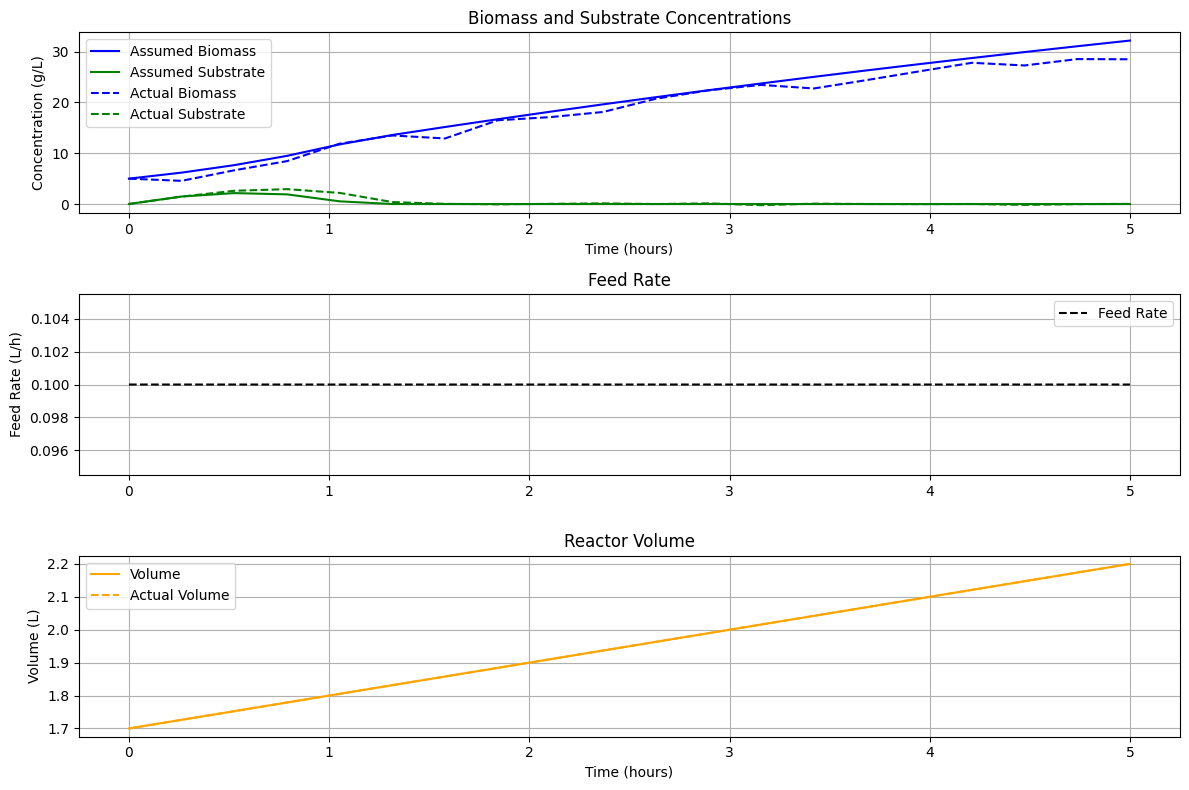

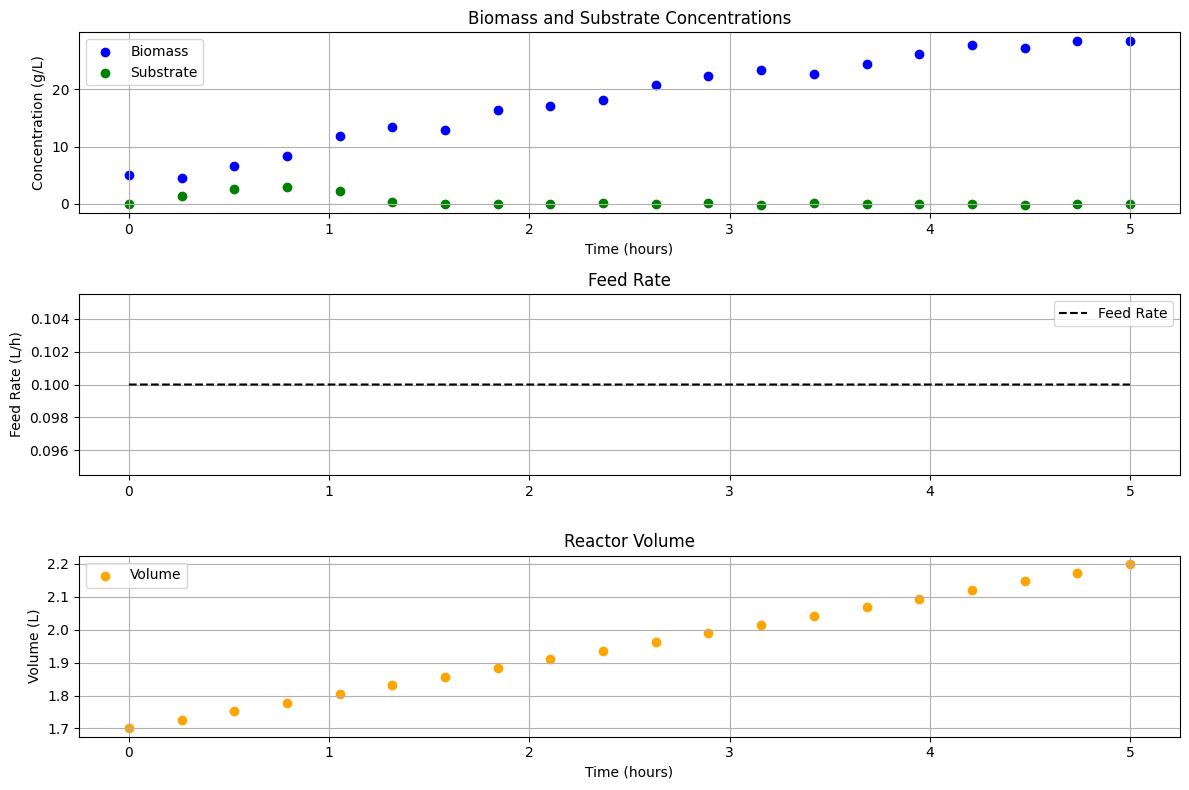

In [10]:
def F_exp(t):
    return 0.1

sol, F_func = simulate(F_exp)

df = pd.DataFrame({
    'Time': sol.t,
    'X': sol.y[0],
    'S': sol.y[1],
    'V': sol.y[2],
    'F': [F_func(t) for t in sol.t]
})

# Plot df   
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(3, 1, 1)
ax1.scatter(df['Time'], df['X'], label='Biomass', color='blue')
ax1.scatter(df['Time'], df['S'], label='Substrate', color='green')
ax1.set_title('Biomass and Substrate Concentrations')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Concentration (g/L)')
ax1.legend(loc='upper left')
ax1.grid()
# Plot Feed Rate
ax2 = plt.subplot(3, 1, 2)
ax2.plot(np.linspace(T_START, T_END, 1000), [F_func(t) for t in np.linspace(T_START, T_END, 1000)], label='Feed Rate', color='black', linestyle='--', drawstyle='steps-post')
ax2.set_ylabel('Feed Rate (L/h)')
ax2.set_title('Feed Rate')
ax2.legend(loc='upper right')
ax2.grid()
# Plot Volume
ax3 = plt.subplot(3, 1, 3)
ax3.scatter(df['Time'], df['V'], label='Volume', color='orange')
ax3.set_title('Reactor Volume')
ax3.set_xlabel('Time (hours)')
ax3.set_ylabel('Volume (L)')
ax3.legend()
ax3.grid()
plt.tight_layout()
plt.show()

In [ ]:
CURRENT_SAMPLES = len(df)
t_meas = df['Time'].iloc[:CURRENT_SAMPLES].values
y_meas = df[['X', 'S']].iloc[:CURRENT_SAMPLES].values  # use only X and S for estimation
y0 = [df['X'].iloc[0], df['S'].iloc[0], df['V'].iloc[0]]

# --- Model with parameters ---
def model(t, y, theta):
    X, S, V = y
    S = max(S, 0)  # Avoid negative substrate concentration
    mu_max, K_s, Y_xs = theta
    F = F_func(t)
    mu = mu_max * S / (K_s + S)
    dX_dt = mu * X - (F / V) * X
    dS_dt = -(1 / Y_xs) * mu * X + (F / V) * (S_F - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

# --- Forward simulation function ---
def simulate(theta):
    sol = solve_ivp(model, args=(theta,), t_span=(t_meas[0], t_meas[-1]), y0=y0, t_eval=t_meas, method='RK45', max_step=0.1)
    return sol.y.T  # shape (N, 3)

# --- Cost function ---
def objective(theta):
    y_sim = simulate(theta)
    error = y_meas - y_sim[:, :2]  # compare X and S only
    return np.sum(error**2)

# --- Initial guess and bounds ---
theta0 = [0.5, 0.5, 0.5]  # [mu_max, K_s, Y_xs]
bounds = [(0.1, 0.9), (1e-4, 1.0), (0.1, 0.8)]

# --- Run estimation ---
res = minimize(objective, theta0, bounds=bounds, method='SLSQP')
theta_est = res.x

print("Estimated parameters:")
print(f"mu_max = {theta_est[0]:.4f}")
print(f"K_s    = {theta_est[1]:.4f}")
print(f"Y_xs   = {theta_est[2]:.4f}")

/home/kostasme/.kostas/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/kostasme/.kostas/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


KeyboardInterrupt: 

In [ ]:
sol_sim = solve_ivp(model, t_span=(T_START, T_END), y0=y0, args=(theta_est,), t_eval=np.linspace(T_START, T_END, 1000), method='RK45')
y_sim_est = sol_sim.y.T  # shape (N, 3)
t_sim_est = sol_sim.t

In [ ]:
# --- Plot results ---
plt.figure(figsize=(12, 4))
plt.plot(df['Time'], df['X'], 'o', label='Measured X', color='blue', alpha=0.5)
plt.plot(df['Time'].iloc[:CURRENT_SAMPLES], df['X'].iloc[:CURRENT_SAMPLES], 'o', label='_Measured X', color='blue', alpha=1)
plt.plot(t_sim_est, y_sim_est[:, 0], label='Estimated X', color='blue', linestyle='--')
plt.plot(df['Time'], df['S'], 'o', label='Measured S', color='green', alpha=0.5)
plt.plot(df['Time'].iloc[:CURRENT_SAMPLES], df['S'].iloc[:CURRENT_SAMPLES], 'o', label='_Measured S', color='green', alpha=1)
plt.plot(t_sim_est, y_sim_est[:, 1], label='Estimated S', color='green', linestyle='--')
plt.title('Biomass and Substrate Concentrations')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.grid()
plt.show()
